## Generate Experiment Climate Forcings Dynamically based on LAI

Use the LANDIS LAI based precipitatioin weights surfaces to create the future precipitation grids for the model.

In [1]:
import gdal
import glob
import ipyparallel as p
import ProgressBar as pb

In [2]:
c = p.Client()
dview = c.direct_view()

In [3]:
%%px
import gdal

In [4]:
force = pd.read_pickle('./data/dynamic_precipitation.pcl')
force['decade'] = (force.year-2000)/10.

In [5]:
def t_force(decade):
    return decade * 0.4

def p_force(df):
    c = 1
    if df.track == 'PGW_LP':
        c *= -1 # make less precip scenarios less
    
    return df.decade * 0.015 * c

force['T'] = force.decade.map(t_force)
force['P'] = force.apply(p_force,axis=1)
force['name'] = np.NaN

In [6]:
def p_force_more(decade):
    return decade * 0.015

def p_force_less(decade):
    return decade * -0.015

## Combinations

There are two combinations of forcings:

- higher T and lower P
- higher T and higher P

There are three years to run the experiment over:

- 2000 - no change in forcings
- 2050 - 50% change in forcings
- 2100 - 100% change in forcings

There are three scenarios for each year and combination

- 1,2,3 for PGW_MP
- 1,2,5 for PGW_LP

## Naming Conventions

- CLC = current land cover
- FLC = future land cover
- CP = current precipitation
- MP = future more precipitation
- LP = future less precipitation
- CT = current temperature
- FT = future temperature

In [7]:
force.loc[force.year==2000,'name'] = 'CLC_CP_CT'

force.loc[(force.year!=2000) & (force.track=='PGW_MP'),'name'] = 'FLC_MP_FT'
force.loc[(force.year!=2000) & (force.track=='PGW_LP'),'name'] = 'FLC_LP_FT'

In [8]:
force.shape

(66, 9)

In [9]:
# add a few more scenarios for the control simulations
############################
# current land cover and less precip, no temp change
# LP
LP1 = pd.DataFrame()
LP1['scenarios'] = [1,2,5]*2
LP1['track'] = 'PGW_LP'
LP1['year'] = 2000
LP1['decade'] = [5,5,5,10,10,10]
LP1['T'] = 0. # no temperature change
LP1['P'] = LP1.decade.map(p_force_less)
LP1['name'] = 'CLC_LP_CT'

# MP
MP1 = pd.DataFrame()
MP1['scenarios'] = [1,2,3]*2
MP1['track'] = 'PGW_MP'
MP1['year'] = 2000
MP1['decade'] = [5,5,5,10,10,10]
MP1['T'] = 0. # no temperature change
MP1['P'] = MP1.decade.map(p_force_less)
MP1['name'] = 'CLC_LP_CT'

# current land cover and more precip, no temp change
# LP
LP2 = pd.DataFrame()
LP2['scenarios'] = [1,2,5]*2
LP2['track'] = 'PGW_LP'
LP2['year'] = 2000
LP2['decade'] = [5,5,5,10,10,10]
LP2['T'] = 0. # no temperature change
LP2['P'] = LP2.decade.map(p_force_more)
LP2['name'] = 'CLC_MP_CT'

# MP
MP2 = pd.DataFrame()
MP2['scenarios'] = [1,2,3]*2
MP2['track'] = 'PGW_MP'
MP2['year'] = 2000
MP2['decade'] = [5,5,5,10,10,10]
MP2['T'] = 0. # no temperature change
MP2['P'] = MP2.decade.map(p_force_more)
MP2['name'] = 'CLC_MP_CT'

# Current land cover, no precipitation change, increased temp
# PGW1
PGW1 = pd.DataFrame()
PGW1['scenarios'] = [1,2,5]*2
PGW1['track'] = 'PGW_LP'
PGW1['year'] = 2000
PGW1['decade'] = [5,5,5,10,10,10]
PGW1['P'] = 0. # no precip change
PGW1['T'] = PGW1.decade.map(t_force)
PGW1['name'] = 'CLC_CP_FT'

# PGW2 
PGW2 = pd.DataFrame()
PGW2['scenarios'] = [1,2,3]*2
PGW2['track'] = 'PGW_MP'
PGW2['year'] = 2000
PGW2['decade'] = [5,5,5,10,10,10]
PGW2['P'] = 0 # no precip change 
PGW2['T'] = PGW2.decade.map(t_force)
PGW2['name'] = 'CLC_CP_FT'

# current land cover, more precipitation, temperature change
tmp1 = pd.DataFrame()
tmp1['scenarios'] = [1,2,3]*2
tmp1['track'] = 'PGW_MP'
tmp1['year'] = 2000
tmp1['decade'] = [5,5,5,10,10,10]
tmp1['P'] = tmp1.decade.map(p_force_more)
tmp1['T'] = tmp1.decade.map(t_force)
tmp1['name'] = 'CLC_MP_FT'

tmp2 = pd.DataFrame()
tmp2['scenarios'] = [1,2,5]*2
tmp2['track'] = 'PGW_LP'
tmp2['year'] = 2000
tmp2['decade'] = [5,5,5,10,10,10]
tmp2['P'] = tmp1.decade.map(p_force_more)
tmp2['T'] = tmp1.decade.map(t_force)
tmp2['name'] = 'CLC_MP_FT'

# current land cover, less precipitation, temperature change
tmp3 = pd.DataFrame()
tmp3['scenarios'] = [1,2,3]*2
tmp3['track'] = 'PGW_MP'
tmp3['year'] = 2000
tmp3['decade'] = [5,5,5,10,10,10]
tmp3['P'] = tmp3.decade.map(p_force_less)
tmp3['T'] = tmp3.decade.map(t_force)
tmp3['name'] = 'CLC_LP_FT'

tmp4 = pd.DataFrame()
tmp4['scenarios'] = [1,2,5]*2
tmp4['track'] = 'PGW_LP'
tmp4['year'] = 2000
tmp4['decade'] = [5,5,5,10,10,10]
tmp4['P'] = tmp4.decade.map(p_force_less)
tmp4['T'] = tmp4.decade.map(t_force)
tmp4['name'] = 'CLC_LP_FT'

tmp = pd.concat([LP1,MP1,LP2,MP2,PGW1,PGW2,tmp1,tmp2,tmp3,tmp4])
tmp['krumlai'] = np.NaN
tmp['krumweight'] = np.NaN

In [10]:
len(tmp)

60

In [11]:
force = pd.concat([force,tmp])

In [12]:
force.to_pickle('./data/experiment_forcing_params_dynamic.pcl')

In [13]:
force.shape

(126, 9)

In [14]:
force.head()

,P,T,decade,krumlai,krumweight,name,scenarios,track,year
0,-0.000,0.0,0.0,2.736959,6.037752,CLC_CP_CT,1,PGW_LP,2000
1,-0.015,0.4,1.0,2.433178,5.131501,FLC_LP_FT,1,PGW_LP,2010
2,-0.030,0.8,2.0,2.352813,4.789137,FLC_LP_FT,1,PGW_LP,2020
3,-0.045,1.2,3.0,2.315622,5.047437,FLC_LP_FT,1,PGW_LP,2030
4,-0.060,1.6,4.0,2.184931,4.737545,FLC_LP_FT,1,PGW_LP,2040


In [15]:
force.tail()

,P,T,decade,krumlai,krumweight,name,scenarios,track,year
1,-0.075,2.0,5.0,NaN,NaN,CLC_LP_FT,2,PGW_LP,2000
2,-0.075,2.0,5.0,NaN,NaN,CLC_LP_FT,5,PGW_LP,2000
3,-0.150,4.0,10.0,NaN,NaN,CLC_LP_FT,1,PGW_LP,2000
4,-0.150,4.0,10.0,NaN,NaN,CLC_LP_FT,2,PGW_LP,2000
5,-0.150,4.0,10.0,NaN,NaN,CLC_LP_FT,5,PGW_LP,2000


In [16]:
# dates to produce gridded data between
strt = '1990-10-01'
nd = '2013-10-05'

# dates to use the snow scaling map
winter_strt = '10-01'
winter_nd = '05-31'

cellsize=60
site_elev = 3018 # met station site elevation in m

months = np.arange(1,13)
temp = [-2.1,-3.3,-5.0,-6.5,-6.2,-5.6,-5.5,-5.6,-5.2,-5.0,-4.5,-2.5] # [degC/km]
precip = [55.1,52.6,64.0,64.2,33.6,17.6,16.0,14.6,17.0,23.2,53.1,42.5] # [mm/km]

lapse = pd.DataFrame({'month':months,'T':temp,'P':precip})
lapse.index = lapse.month

lapse.P /= (1000.*1000.) # [mm/km] > [m/m]
lapse.T = lapse['T'].as_matrix()/1000. # [deg C/km] > [deg C/m]

# load the met data
c1 = pd.read_pickle('./data/c1_met_jennings_QAQC_corrP.pcl')[strt:nd]

fl = '/RHESSys/Como/auxdata/gridmet_dem_%sm_crop.tiff'%cellsize
ds = gdal.Open(fl)
dem = np.array(ds.GetRasterBand(1).ReadAsArray())

fl = '/RHESSys/Como/auxdata/gridmet_index_%sm_crop.tiff'%cellsize
ds = gdal.Open(fl)
idx = np.array(ds.GetRasterBand(1).ReadAsArray())

l,k = dem.shape
n = l*k

# reshape the rasters all in the same way
dem.shape = n
idx.shape = n

header = '%s\n%s %s %s 1'%(n,c1.index[0].year,c1.index[0].month, c1.index[0].day)

In [17]:
def grid_data(deltaT,deltaP,track,scenario,Year):
    
    # load the met data
    c1 = pd.read_pickle('./data/c1_met_jennings_QAQC_corrP.pcl')[strt:nd]
    
    # alter the forcings according to delta T and delta P
    c1.Tmin += deltaT
    c1.Tmax += deltaT
    c1.P *= (1.+deltaP)
    
    # load the weights
    scaled = np.load('./data/RHESSys_scenarios/LANDIS_Pweight_%s_%s_%s.npy'%(track,scenario,Year))
    scaled.shape = n # reshape the weights
    
    out = pd.DataFrame(np.ndarray((len(c1)+2,n)))
    out.iloc[0,:] = idx # add the index numbers to the data frame
    out.iloc[1,:] = dem # add the dem values to the data frame

    # make copies of the data frame for population
    Tmax = out.copy()
    Tmin = out.copy()
    P = out.copy()

    elev_diff = dem - site_elev
    winter_strt_month = int(winter_strt.split('-')[0])
    winter_strt_day = int(winter_strt.split('-')[1])
    winter_nd_month = int(winter_nd.split('-')[0])
    winter_nd_day = int(winter_nd.split('-')[1])

    ct = 2 # start at 2 b/c the first 2 rows are full
    bar = pb.ProgressBar(len(c1.index))
    for day in c1.index:

        year = int(day.year)
        month = day.month

        # compute the start and end of the winter time period
        winter_strt2 = pd.datetime(year,winter_strt_month,winter_strt_day)
        winter_nd2 = pd.datetime(year,winter_nd_month,winter_nd_day)

        tlapse = lapse.loc[lapse.month==month,'T'].as_matrix()[0] # pull out the temp. lapse rate
        plapse = lapse.loc[lapse.month==month,'P'].as_matrix()[0] # pull out the precip. lapse rate    
        #plapse = 0.000015 # static precip lapse rate m/m
        
        # compute the temperature of each cell
        Tmax.iloc[ct,:] = c1.loc[day].Tmax + (tlapse*elev_diff)
        Tmin.iloc[ct,:] = c1.loc[day].Tmin + (tlapse*elev_diff)
        
        # use the below scheme for years where there is no temperature change.
        if deltaT == 0:
            if (day>winter_nd2) & (day<winter_strt2) & (c1.loc[day].P > 0): # test if the day is during the summer
                # distribute summer precip based on published lapse rates
                P.iloc[ct,:] = c1.loc[day].P + (plapse*elev_diff)

                #if c1.loc[day].P > 0:# ensure that there is actually precipitation
            else: #f the day is during winter
                # distribute winter precip based on the Jepsen reconstruction
                P.iloc[ct,:] = c1.loc[day].P * scaled
        else: # for future years:
            # compute the proportion of snow and rain at each grid cell based on min and max temperatures as well as
            # the minimum rain and maximum snow temperatures optimized in RHESSys.
            
            ## create a DataFrame
            props = pd.DataFrame()
            props['Tmin'] = Tmin.iloc[ct,:].as_matrix() # grab the min temp as array
            props['Tmax'] = Tmax.iloc[ct,:].as_matrix() # grab the max temp as array
            props['lapsedP'] = c1.loc[day].P + (plapse*elev_diff) # precipitation as all rain
            props['scaledP'] = c1.loc[day].P * scaled # precipitation as all snow
            props['snow'] = compute_snowFallFraction(props.Tmin.as_matrix(),props.Tmax.as_matrix(),props.lapsedP.as_matrix())
            #props['snow'] = props.apply(compute_snowFallFraction,axis=1, minRain = minRain, maxSnow = maxSnow)
            props['rain'] = 1. - props.snow # compute rain fraction
            props['P'] = compute_weightedP(props.snow,props.scaledP,props.rain,props.lapsedP)
            #props['P'] = props.apply(compute_weightedP,axis=1) # compute precip and the weighted average of lapsed and scaled P
            
            P.iloc[ct,:] = props.P.as_matrix() # insert P into the matrix
            
        bar.animate_ipython(ct)
        ct+=1

    # convert the data frames to numpy arrays
    Tmax = Tmax.as_matrix()
    Tmin = Tmin.as_matrix()
    P = P.as_matrix()

    P[P<0] = 0. # precip that is for some reason negative should be zeroed
    
    return Tmin,Tmax,P

In [18]:
#@dview.parallel(block=True)
def compute_snowFallFraction(Tmin,Tmax,lapsedP):
    '''RHESSys source code, Tague and Band 2004'''
    #Tmin = df.Tmin
    #Tmax = df.Tmax
    Tavg = np.nanmean([Tmin,Tmax]) # compute average T
    
    minRain = -2.561700 # minimum rainfall temperature
    maxSnow = 3.032986 # maximum snowfall temperature
    
    rain = lapsedP # start with the idea that all the P is rain
    
    if Tavg < maxSnow:
        if Tavg <= minRain:
            snow = rain
            rain = 0.    
        else:
            snow_rain_range = maxSnow - minRain
            if snow_rain_range < 0.001:
                print 'Limited Range'
                snow = rain
                rain = 0.
            else:
                snow = np.nanmin([(maxSnow - Tavg)*rain / snow_rain_range,rain])
                rain = rain - snow
        
    else:
        snow = 0.0
            
    totalP = snow + rain
    propSnow = snow/totalP
        
    return propSnow # return the proportion of precip is rain

In [19]:
def compute_weightedP(snow,scaledP,rain,lapsedP):
    #print df.snow
    #print df.scaledP
    #print df.rain
    #print df.lapsedP
    #if (df.snow is None) | (df.scaledP is None) | (df.rain is None) | (df.lapsedP is None):
    #    print 'Variable Missing!'
    #    print df.snow.dtype()
    #    print df.scaledP.dtype()
    #    print df.rain.dtype()
    #    print df.lapsedP.dtype()
    
    #return (df.snow * df.scaledP) + (df.rain * df.lapsedP) # compute a weighted average
    return (snow * scaledP) + (rain * lapsedP)

In [20]:
# define a function that runs the gridding function over the forcing data frame

def gen_forcings(df):
    #year,track,scenario,decade,name,deltaT,deltaP
    # extract things for naming
    year = int(df['year'])
    #year = int(year)
    track = df['track']
    scenario = df['scenarios']
    decade = int(df['decade'])
    #decade = int(decade)
    name = df['name']
    
    # extract perturbations
    deltaT = df['T']
    deltaP = df['P']
    
    # grid out the data
    Tmin,Tmax,P = grid_data(deltaT,deltaP,track,scenario,year)
    
    # save the data
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_%s_%s_%s_%s_%s.tmax'%(cellsize,track,scenario,year,decade,name),Tmax,header=header,comments='',fmt='%3.2f')
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_%s_%s_%s_%s_%s.tmin'%(cellsize,track,scenario,year,decade,name),Tmin,header=header,comments='',fmt='%3.2f')
    np.savetxt('/RHESSys/Como/clim/exp/grid%s_%s_%s_%s_%s_%s.rain'%(cellsize,track,scenario,year,decade,name),P,header=header,comments='',fmt='%3.6f')
    
    # generate the summary data
    check_P = pd.DataFrame({'Tmax':np.mean(Tmax[2:,:],axis=1),'Tmin':np.mean(Tmin[2:,:],axis=1),
                             'P':np.mean(P[2:,:],axis=1)},index = c1.index)
    
    # save the summary data
    check_P.to_pickle('/RHESSys/Como/clim/exp/grid%s_%s_%s_%s_%s_%s.pcl'%(cellsize,track,scenario,year,decade,name))
    
    return None

In [ ]:
force.apply(gen_forcings,axis=1)

[****************100%******************]  8407 of 8406 complete

In [29]:
#year,track,scenario,decade,name,deltaT,deltaP
res = view.map(gen_forcings,force.year,force.track,force.scenarios,force.decade,force.name,force.T,force.P)

In [32]:
res.ready()

True

In [33]:
res.result()

CompositeError: one or more exceptions from call to method: gen_forcings
[5:apply]: NameError: global name 'grid_data' is not defined
[2:apply]: NameError: global name 'grid_data' is not defined
[7:apply]: NameError: global name 'grid_data' is not defined
[3:apply]: NameError: global name 'grid_data' is not defined
.... 122 more exceptions ...

In [36]:
res.ready()

True

In [30]:
force.head()

,P,T,decade,krumlai,krumweight,name,scenarios,track,year
0,-0.000,0.0,0.0,2.736959,6.037752,CLC_CP_CT,1,PGW_LP,2000
1,-0.015,0.4,1.0,2.433178,5.131501,FLC_LP_FT,1,PGW_LP,2010
2,-0.030,0.8,2.0,2.352813,4.789137,FLC_LP_FT,1,PGW_LP,2020
3,-0.045,1.2,3.0,2.315622,5.047437,FLC_LP_FT,1,PGW_LP,2030
4,-0.060,1.6,4.0,2.184931,4.737545,FLC_LP_FT,1,PGW_LP,2040


In [24]:
res.ready()

True

In [27]:
res.result()

CompositeError: one or more exceptions from call to method: gen_forcings
[3:apply]: TypeError: string indices must be integers, not str
[7:apply]: TypeError: string indices must be integers, not str
[5:apply]: TypeError: string indices must be integers, not str
[0:apply]: TypeError: string indices must be integers, not str
.... 122 more exceptions ...

In [77]:
force.apply(gen_forcings,axis=1)

KeyboardInterrupt: 

In [30]:
tmp = 2

In [31]:
tmp

2

In [85]:
# get all the summary files 
files = glob.glob('/RHESSys/Como/clim/exp/grid%s*.pcl'%(cellsize))

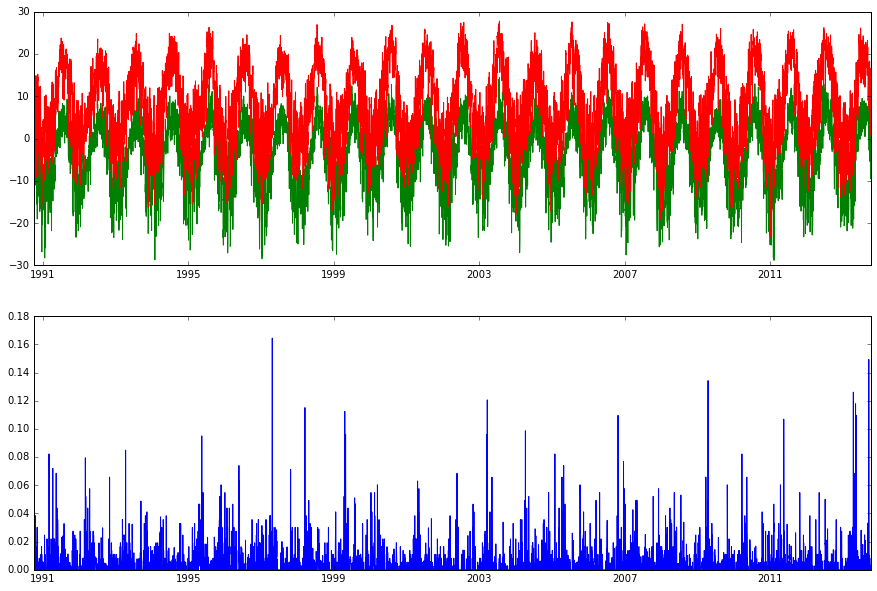

In [88]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for fl in files[:1]:
    tmp = pd.read_pickle(fl)
    ax1.plot(tmp.Tmin,'-g')
    ax1.plot(tmp.Tmax,'-r')
    
    ax2.plot(tmp.P,'-b')
